# **Initialisation**

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from keras.callbacks import CSVLogger
import random
import cv2
from sklearn.utils import shuffle
import skimage.measure

In [ ]:
!pip install pyyaml h5py

In [ ]:
(trainx, trainy), (testx, testy) = mnist.load_data()

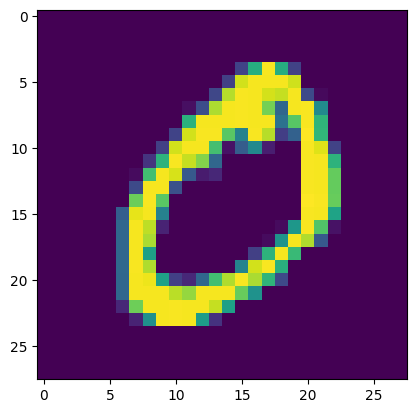

In [ ]:
plt.imshow(trainx[1])

In [ ]:
trainy[1]

0

# **Large CNNs**

## Model

In [ ]:
trainxmm = trainx/255.0
testxmm = testx/255.0

In [ ]:
# trainxmm = np.expand_dims(trainxmm, axis=3)
# testxmm = np.expand_dims(trainxmm, axis=3)

In [ ]:
# trainxmm.shape

**Wider layer**

In [ ]:
def metric(y_true,y_pred):
  # print(type(y_true))
  result = y_pred * tf.transpose(y_true)
  return tf.reduce_sum(result)/2*tf.shape(result)

In [ ]:
model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomR  (None, 14, 14, 1)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 1000)              50177000  
                                                                 
 dense_3 (Dense)             (None, 11)                11011     
                                                      

In [ ]:
def add_f_train(trainy,n):
  trainy_new = np.zeros((trainy.shape[0],n+1))
  for i in range(trainy.shape[0]):
    trainy_new[i,trainy[i] + 1] = 1
    trainy_new[i,0] = 0

  return trainy_new

In [ ]:
def add_non_numbers(x, y):
  trainx_new = np.zeros((x.shape[0]*11//10, x.shape[1], x.shape[2]))
  trainy_new = np.zeros((y.shape[0]*11//10, y.shape[1]))

  trainx_new [:x.shape[0]] = x
  for i in range(x.shape[0]//10):
    trainx_new [x.shape[0]+i] = np.random.rand(x.shape[1],x.shape[2])/random.randint(1,100)

  trainy_new [:y.shape[0]] = y
  trainy_new [y.shape[0]:,0] = np.ones(y.shape[0]*1//10)

  return shuffle(trainx_new, trainy_new)

In [ ]:
def add_lines(x):
  a = random.randint(1,4)
  if a == 1:
    cv2.line(x,
          (0,random.randint(0,X.shape[1]-1)),
          (X.shape[2]-1,random.randint(0,X.shape[1]-1)),
          (1,1,1),
          random.randint(2,2))/255

  elif a == 2:
    cv2.line(x,
          (random.randint(0,X.shape[2]-1),0),
          (random.randint(0,X.shape[2]-1),X.shape[1]-1),
          (1,1,1),
          random.randint(2,2))/255

  elif a == 3:
    cv2.line(x,
          (0,random.randint(0,X.shape[1]-1)),
          (random.randint(0,X.shape[2]-1),X.shape[1]-1),
          (1,1,1),
          random.randint(2,2))/255

  else:
    cv2.line(x,
          (random.randint(0,X.shape[2]-1),0),
          (X.shape[2]-1, random.randint(0,X.shape[1]-1)),
          (1,1,1),
          random.randint(2,2))/255

In [ ]:
def reduce(xmm,n=2):
  x = np.zeros((xmm.shape[0], xmm.shape[1]//n, xmm.shape[2]//n))
  for i in range(xmm.shape[0]):
    x[i] = skimage.measure.block_reduce(xmm[i], (n,n), np.max)

  return x

In [ ]:
trainy_new = add_f_train(trainy,10)
testy_new = add_f_train(testy,10)

In [ ]:
trainy_new[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
xmm = reduce(trainxmm, n=2)
xmm_val = reduce(testxmm, n=2)

In [ ]:
X,y = add_non_numbers(xmm, trainy_new)

In [ ]:
for i in range((X.shape[0])//2):
  add_lines(X[i])

In [ ]:
X,y = shuffle(X,y)

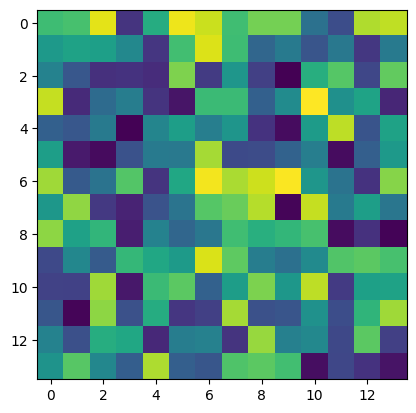

In [ ]:
plt.imshow(X[242])

In [ ]:
y[234]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

## Training

In [ ]:
from tqdm import tqdm

checkpoint_path = "training_1/val_loss.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger('training_log.csv', append=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 verbose=1)

# Train the model with the new callback
for i in tqdm(range(100)):


  X,y = add_non_numbers(xmm, trainy_new)

  for i in range((X.shape[0])//2):
    add_lines(X[i])

  X,y = shuffle(X,y)


  X_val,y_val = add_non_numbers(xmm_val, testy_new)

  for i in range((X_val.shape[0])//2):
    add_lines(X_val[i])

  X_val,y_val = shuffle(X_val,y_val)


  model.fit(X,
    y,
    epochs=1,
    batch_size = 1000,
    validation_data=(X_val, y_val),
    callbacks=[csv_logger])

  0%|          | 0/100 [00:00<?, ?it/s]

66/66 [==============================] - 10s 127ms/step - loss: 0.0882 - categorical_accuracy: 0.0937 - val_loss: 0.0841 - val_categorical_accuracy: 0.0909


  1%|          | 1/100 [00:11<18:27, 11.18s/it]

66/66 [==============================] - 9s 132ms/step - loss: 0.0832 - categorical_accuracy: 0.0909 - val_loss: 0.0828 - val_categorical_accuracy: 0.0909


  2%|▏         | 2/100 [00:22<18:43, 11.46s/it]

66/66 [==============================] - 9s 132ms/step - loss: 0.0827 - categorical_accuracy: 0.0909 - val_loss: 0.0827 - val_categorical_accuracy: 0.0915


  3%|▎         | 3/100 [00:34<19:00, 11.76s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0827 - categorical_accuracy: 0.0912 - val_loss: 0.0827 - val_categorical_accuracy: 0.1349


  4%|▍         | 4/100 [00:45<18:21, 11.47s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0826 - categorical_accuracy: 0.1324 - val_loss: 0.0826 - val_categorical_accuracy: 0.1236


  5%|▌         | 5/100 [00:54<16:29, 10.41s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0841 - categorical_accuracy: 0.1406 - val_loss: 0.0827 - val_categorical_accuracy: 0.0909


  6%|▌         | 6/100 [01:05<16:37, 10.61s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0827 - categorical_accuracy: 0.0909 - val_loss: 0.0827 - val_categorical_accuracy: 0.0913


  7%|▋         | 7/100 [01:14<15:22,  9.92s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0826 - categorical_accuracy: 0.0909 - val_loss: 0.0827 - val_categorical_accuracy: 0.0910


  8%|▊         | 8/100 [01:22<14:44,  9.62s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0826 - categorical_accuracy: 0.0909 - val_loss: 0.0827 - val_categorical_accuracy: 0.0915


  9%|▉         | 9/100 [01:34<15:15, 10.06s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0826 - categorical_accuracy: 0.0909 - val_loss: 0.0827 - val_categorical_accuracy: 0.0923


 10%|█         | 10/100 [01:42<14:27,  9.64s/it]

66/66 [==============================] - 8s 123ms/step - loss: 0.0826 - categorical_accuracy: 0.0909 - val_loss: 0.0827 - val_categorical_accuracy: 0.0935


 11%|█         | 11/100 [01:53<14:54, 10.06s/it]

66/66 [==============================] - 8s 124ms/step - loss: 0.0826 - categorical_accuracy: 0.0910 - val_loss: 0.0827 - val_categorical_accuracy: 0.0946


 12%|█▏        | 12/100 [02:04<15:10, 10.34s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0826 - categorical_accuracy: 0.0910 - val_loss: 0.0827 - val_categorical_accuracy: 0.0995


 13%|█▎        | 13/100 [02:15<15:17, 10.54s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0826 - categorical_accuracy: 0.0910 - val_loss: 0.0827 - val_categorical_accuracy: 0.1055


 14%|█▍        | 14/100 [02:26<15:18, 10.68s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0826 - categorical_accuracy: 0.0910 - val_loss: 0.0826 - val_categorical_accuracy: 0.1065


 15%|█▌        | 15/100 [02:37<15:16, 10.78s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0826 - categorical_accuracy: 0.0910 - val_loss: 0.0827 - val_categorical_accuracy: 0.1085


 16%|█▌        | 16/100 [02:48<15:10, 10.84s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0826 - categorical_accuracy: 0.0910 - val_loss: 0.0826 - val_categorical_accuracy: 0.1121


 17%|█▋        | 17/100 [02:59<15:03, 10.88s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0826 - categorical_accuracy: 0.0913 - val_loss: 0.0827 - val_categorical_accuracy: 0.1293


 18%|█▊        | 18/100 [03:08<13:55, 10.19s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0826 - categorical_accuracy: 0.0918 - val_loss: 0.0827 - val_categorical_accuracy: 0.1357


 19%|█▉        | 19/100 [03:16<13:04,  9.69s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0848 - categorical_accuracy: 0.1067 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 20%|██        | 20/100 [03:25<12:26,  9.34s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 21%|██        | 21/100 [03:33<11:47,  8.96s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0882


 22%|██▏       | 22/100 [03:41<11:22,  8.75s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 23%|██▎       | 23/100 [03:52<12:05,  9.42s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 24%|██▍       | 24/100 [04:03<12:31,  9.89s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0884


 25%|██▌       | 25/100 [04:11<11:41,  9.35s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0884


 26%|██▌       | 26/100 [04:20<11:14,  9.11s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 27%|██▋       | 27/100 [04:31<11:46,  9.68s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 28%|██▊       | 28/100 [04:39<11:04,  9.23s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 29%|██▉       | 29/100 [04:50<11:32,  9.75s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 30%|███       | 30/100 [05:01<11:49, 10.13s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 31%|███       | 31/100 [05:12<11:56, 10.39s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 32%|███▏      | 32/100 [05:20<10:59,  9.69s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 33%|███▎      | 33/100 [05:31<11:20, 10.16s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 34%|███▍      | 34/100 [05:39<10:29,  9.54s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 35%|███▌      | 35/100 [05:47<09:51,  9.10s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 36%|███▌      | 36/100 [05:58<10:20,  9.69s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 37%|███▋      | 37/100 [06:09<10:35, 10.08s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 38%|███▊      | 38/100 [06:21<10:43, 10.38s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 39%|███▉      | 39/100 [06:32<10:44, 10.57s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 40%|████      | 40/100 [06:40<09:49,  9.83s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 41%|████      | 41/100 [06:51<10:00, 10.18s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 42%|████▏     | 42/100 [07:02<10:05, 10.44s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 43%|████▎     | 43/100 [07:10<09:15,  9.74s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 44%|████▍     | 44/100 [07:21<09:26, 10.12s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 45%|████▌     | 45/100 [07:29<08:43,  9.52s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 46%|████▌     | 46/100 [07:40<09:03, 10.07s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 47%|████▋     | 47/100 [07:48<08:22,  9.48s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 48%|████▊     | 48/100 [07:59<08:36,  9.93s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 49%|████▉     | 49/100 [08:10<08:42, 10.25s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 50%|█████     | 50/100 [08:21<08:43, 10.47s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 51%|█████     | 51/100 [08:30<07:59,  9.78s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 52%|█████▏    | 52/100 [08:38<07:30,  9.39s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 53%|█████▎    | 53/100 [08:49<07:43,  9.87s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0883


 54%|█████▍    | 54/100 [09:00<07:49, 10.20s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0886 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 55%|█████▌    | 55/100 [09:11<07:49, 10.44s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 56%|█████▌    | 56/100 [09:19<07:09,  9.76s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 57%|█████▋    | 57/100 [09:27<06:38,  9.26s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0884


 58%|█████▊    | 58/100 [09:38<06:50,  9.78s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 59%|█████▉    | 59/100 [09:49<06:55, 10.14s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 60%|██████    | 60/100 [09:57<06:21,  9.53s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 61%|██████    | 61/100 [10:08<06:28,  9.97s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 62%|██████▏   | 62/100 [10:17<06:00,  9.49s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 63%|██████▎   | 63/100 [10:25<05:39,  9.18s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 64%|██████▍   | 64/100 [10:36<05:50,  9.73s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 65%|██████▌   | 65/100 [10:47<05:53, 10.10s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 66%|██████▌   | 66/100 [10:55<05:22,  9.49s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 67%|██████▋   | 67/100 [11:06<05:27,  9.94s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 68%|██████▊   | 68/100 [11:14<05:00,  9.39s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0884


 69%|██████▉   | 69/100 [11:23<04:42,  9.13s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 70%|███████   | 70/100 [11:34<04:50,  9.68s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 71%|███████   | 71/100 [11:45<04:52, 10.08s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 72%|███████▏  | 72/100 [11:53<04:25,  9.48s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 73%|███████▎  | 73/100 [12:04<04:28,  9.94s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 74%|███████▍  | 74/100 [12:15<04:26, 10.25s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0883


 75%|███████▌  | 75/100 [12:23<04:00,  9.61s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 76%|███████▌  | 76/100 [12:31<03:39,  9.15s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 77%|███████▋  | 77/100 [12:42<03:43,  9.71s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 78%|███████▊  | 78/100 [12:53<03:41, 10.09s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 79%|███████▉  | 79/100 [13:01<03:21,  9.58s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 80%|████████  | 80/100 [13:10<03:04,  9.20s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 81%|████████  | 81/100 [13:21<03:05,  9.74s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 82%|████████▏ | 82/100 [13:32<03:02, 10.12s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0883


 83%|████████▎ | 83/100 [13:40<02:42,  9.53s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 84%|████████▍ | 84/100 [13:48<02:25,  9.10s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 85%|████████▌ | 85/100 [13:56<02:13,  8.90s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 86%|████████▌ | 86/100 [14:04<02:01,  8.66s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 87%|████████▋ | 87/100 [14:13<01:51,  8.59s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 88%|████████▊ | 88/100 [14:21<01:41,  8.48s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 89%|████████▉ | 89/100 [14:32<01:41,  9.24s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 90%|█████████ | 90/100 [14:43<01:37,  9.76s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 91%|█████████ | 91/100 [14:54<01:31, 10.14s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 92%|█████████▏| 92/100 [15:05<01:23, 10.39s/it]

66/66 [==============================] - 7s 112ms/step - loss: 0.0909 - categorical_accuracy: 0.0886 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 93%|█████████▎| 93/100 [15:16<01:14, 10.58s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0884


 94%|█████████▍| 94/100 [15:27<01:04, 10.70s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 95%|█████████▌| 95/100 [15:36<00:50, 10.02s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 96%|█████████▌| 96/100 [15:47<00:41, 10.42s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 97%|█████████▋| 97/100 [15:56<00:29,  9.93s/it]

66/66 [==============================] - 7s 111ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 98%|█████████▊| 98/100 [16:04<00:18,  9.37s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


 99%|█████████▉| 99/100 [16:15<00:09,  9.85s/it]

66/66 [==============================] - 7s 110ms/step - loss: 0.0909 - categorical_accuracy: 0.0887 - val_loss: 0.0909 - val_categorical_accuracy: 0.0885


100%|██████████| 100/100 [16:23<00:00,  9.83s/it]


In [ ]:
logs = pd.read_csv('training_log.csv')

In [ ]:
logs['val_categorical_accuracy'].max()

0.9570909142494202

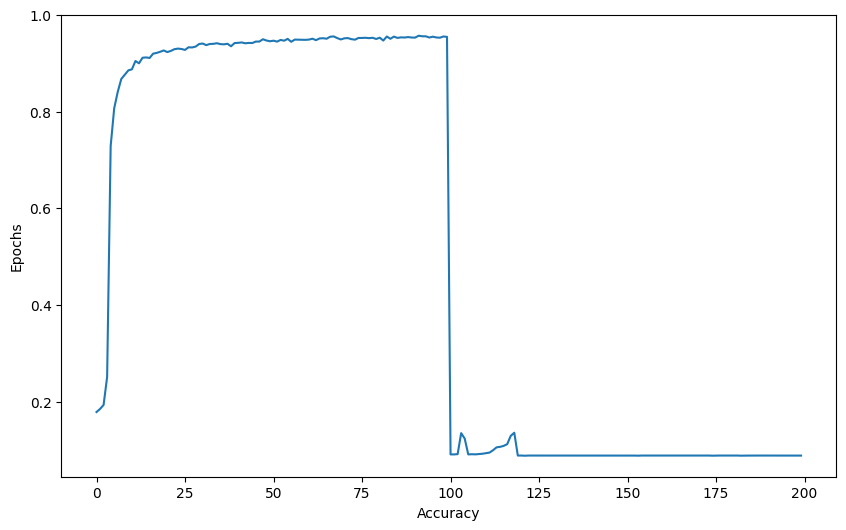

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(logs['val_categorical_accuracy'])
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [ ]:
X_val,y_val = add_non_numbers(xmm_val, testy_new)

for i in range((X_val.shape[0])//2):
  add_lines(X_val[i])

X_val,y_val = shuffle(X_val,y_val)

In [ ]:
model.evaluate(X_val, y_val)

344/344 [==============================] - 1s 4ms/step - loss: 0.0909 - categorical_accuracy: 0.0883


[0.09090947359800339, 0.08827272802591324]

In [ ]:
prediction = model.predict(X_val)

344/344 [==============================] - 1s 2ms/step


In [ ]:
y_val

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

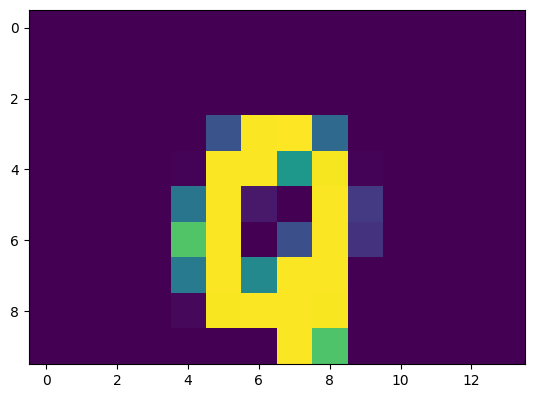

In [ ]:
plt.imshow(X_val[3][:10])

In [ ]:
X_val[3]

In [ ]:
y_val[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
prediction[3]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.1694766e-32,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 5.8315255e-23, 0.0000000e+00], dtype=float32)

In [ ]:
y_pred = np.array([np.argmax(i) for i in prediction])

In [ ]:
y_true = np.array([np.argmax(i) for i in y_val])

In [ ]:
y_true

array([1, 4, 5, ..., 1, 3, 1])

In [ ]:
y_pred

array([9, 9, 9, ..., 9, 9, 9])

In [ ]:
np.sum((y_true == y_pred).astype(int))/y_true.shape[0]

0.08827272727272727

In [ ]:
cnf_mat = tf.math.confusion_matrix(labels = y_true, predictions = y_pred)
cnf_mat

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[   0,    0,    0,    0,    0,    0,    0,    0,    0, 1000,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0,  979,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1135,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1032,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1010,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  982,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  892,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  958,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1028,    0],
       [   3,    0,    0,    0,    0,    0,    0,    0,    0,  971,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1009,    0]],
      dtype=int32)>

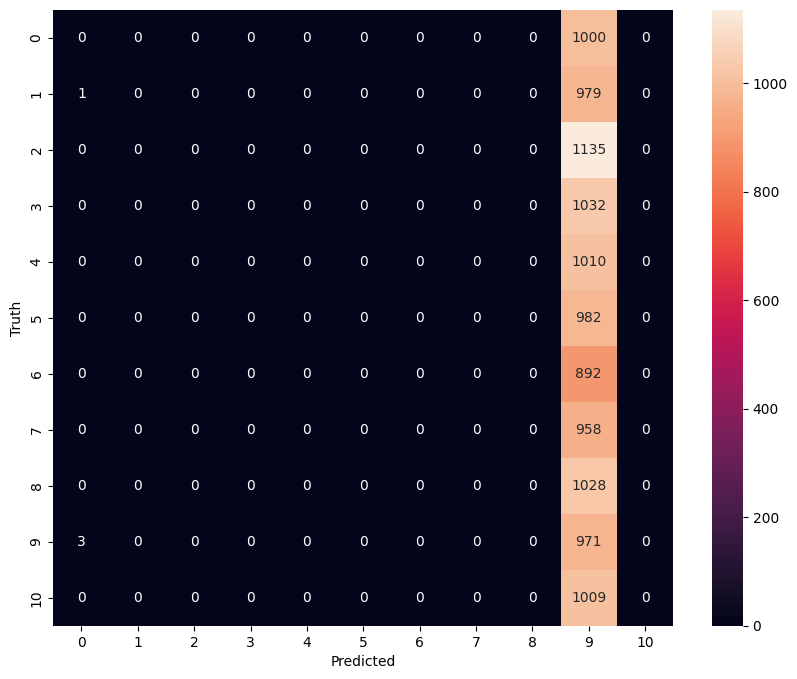

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(cnf_mat, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
y_true_pr = np.zeros(y_true.shape)
y_true_pr[y_true != 0] = 1

y_pred_pr = np.zeros(y_pred.shape)
y_pred_pr[y_pred != 0] = 1

In [ ]:
np.sum((y_true_pr == y_pred_pr).astype(int))/y_true_pr.shape[0]

0.9087272727272727

In [ ]:
model.save('number_detection.keras')

In [ ]:
# Save the weights
model.save_weights('./checkpoints/Tata_Steel_Model')

In [ ]:
new_model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

new_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomR  (None, 14, 14, 1)         0         
 otation)                                                        
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 1000)              50177000  
                                                                 
 dense_5 (Dense)             (None, 11)                11011     
                                                      

In [ ]:
# Restore the weights
new_model.load_weights('./checkpoints/Tata_Steel_Model')

In [ ]:
new_model.evaluate(X_val, y_val)

344/344 [==============================] - 2s 5ms/step - loss: 0.0909 - categorical_accuracy: 0.0883


[0.09090947359800339, 0.08827272802591324]

## Large Network

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(3136, activation = 'relu'),
    keras.layers.Dense(196, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

In [ ]:
checkpoint_path = "training_1/val_loss.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger('training_log2.csv', append=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 verbose=1)

# Train the model with the new callback
model.fit(trainxmm,
          trainy,
          epochs=100,
          batch_size = 1000,
          validation_data=(testxmm, testy),
          callbacks=[csv_logger])

In [ ]:
logs2 = pd.read_csv('training_log2.csv')

In [ ]:
logs2['val_accuracy'].max()

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(logs['val_accuracy'], color='blue')
plt.plot(logs2['val_accuracy'], color='orange')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [ ]:
model.evaluate(testxmm, testy)